# Technical exercise

### Exploratory data analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
print('GPU is', "available" if len(tf.config.experimental.list_physical_devices('GPU'))>0 else "NOT AVAILABLE")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input

import xgboost

Init Plugin
GPU is available
Init Graph Optimizer
Init Kernel


In [5]:
data = pd.read_json('../data/street_group_data_science_bedrooms_test.json', lines = True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   property_type           1000000 non-null  object 
 1   total_floor_area        1000000 non-null  float64
 2   number_habitable_rooms  1000000 non-null  int64  
 3   number_heated_rooms     1000000 non-null  int64  
 4   estimated_min_price     1000000 non-null  int64  
 5   estimated_max_price     1000000 non-null  int64  
 6   latitude                1000000 non-null  float64
 7   longitude               1000000 non-null  float64
 8   bedrooms                1000000 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 68.7+ MB


In [7]:
data.describe()

,total_floor_area,number_habitable_rooms,number_heated_rooms,estimated_min_price,estimated_max_price,latitude,longitude,bedrooms
count,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000,1000000.000000
mean,95.110280,4.731386,4.644062,3.258840e+05,3.768346e+05,52.341382,-1.304311,2.869454
std,77.209212,1.662938,1.677080,2.946820e+05,3.555607e+05,1.130432,1.298806,0.978529
min,0.000000,1.000000,0.000000,1.000000e+04,1.500000e+04,49.912711,-6.312345,0.000000
25%,68.812750,4.000000,4.000000,1.670000e+05,1.920000e+05,51.460908,-2.187931,2.000000
50%,85.000000,5.000000,5.000000,2.560000e+05,2.930000e+05,52.093607,-1.328639,3.000000
75%,108.000000,6.000000,5.000000,3.920000e+05,4.490000e+05,53.359308,-0.251483,3.000000
max,60506.700000,83.000000,83.000000,1.906000e+07,2.858000e+07,55.879634,1.757928,9.000000


Text(0.5, 1.0, 'Number of bedrooms')

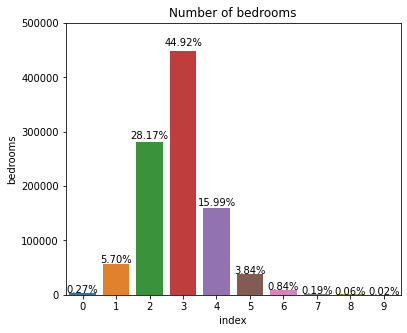

In [8]:
fig, ax = plt.subplots(figsize = (6,5))

p = sns.barplot(x = 'index', 
                y = 'bedrooms', 
                data = data['bedrooms'].value_counts().to_frame().reset_index(), 
                orient = 'vertical',
                ax = ax)


for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate('{:2.2f}%'.format(height/len(data)*100), 
                (x + width/2, y + height*1.02), 
                ha='center', fontsize = 10)
ax.set_ylim(0,500000)
ax.set_title('Number of bedrooms')

Text(0.5, 1.0, 'Property types')

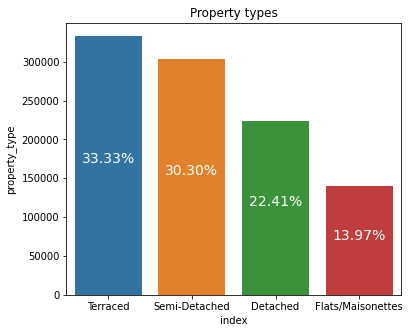

In [9]:
fig, ax = plt.subplots(figsize = (6,5))

p = sns.barplot(x = 'index', 
                y = 'property_type', 
                data = data['property_type'].value_counts().to_frame().reset_index(), 
                orient = 'vertical',
                ax = ax)


for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.annotate('{:2.2f}%'.format(height/len(data)*100), 
                (x + width/2, y + height*1.02/2), 
                ha='center', fontsize = 14, color = 'white')
    
ax.set_title('Property types')

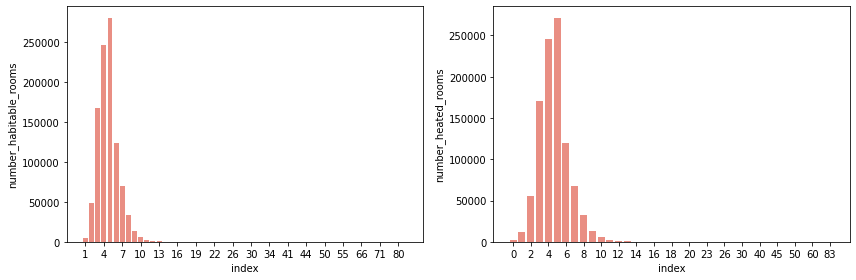

In [10]:
fig, ax = plt.subplots(1, 2, figsize = (12,4))

features = ['number_habitable_rooms', 'number_heated_rooms']

for axx, ft in zip(ax, features):
    p = sns.barplot(x = 'index', 
                    y = ft, 
                    data = data[ft].value_counts().to_frame().reset_index(), 
                    orient = 'vertical',
                    ax = axx,
                    color = 'salmon')
    axx.locator_params(axis = 'x', nbins = 25)

plt.tight_layout()

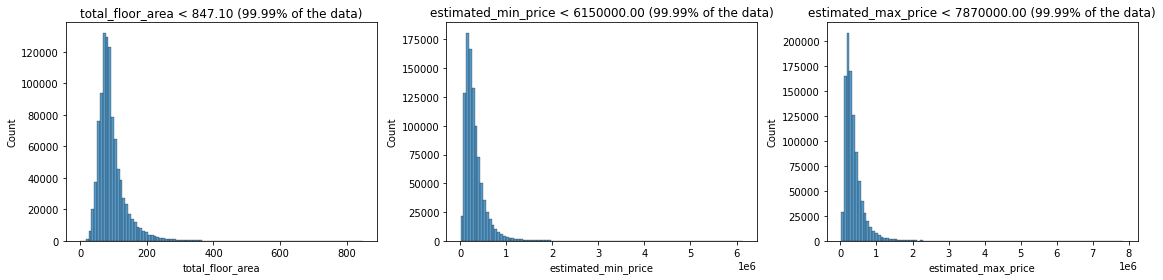

In [11]:
fig, ax = plt.subplots(1, 3, figsize = (16,4))

features = ['total_floor_area','estimated_min_price','estimated_max_price']
quant = 0.9999

for axx, ft in zip(ax,features):
    plot_data = data[data[ft] < data[ft].quantile(quant)][ft]
    sns.histplot(plot_data, bins=100, ax = axx)
    axx.set_title('{:s} < {:2.2f} ({:2.2f}% of the data)'.format(ft, data[ft].quantile(quant), len(plot_data)/len(data)*100))
    
plt.tight_layout()

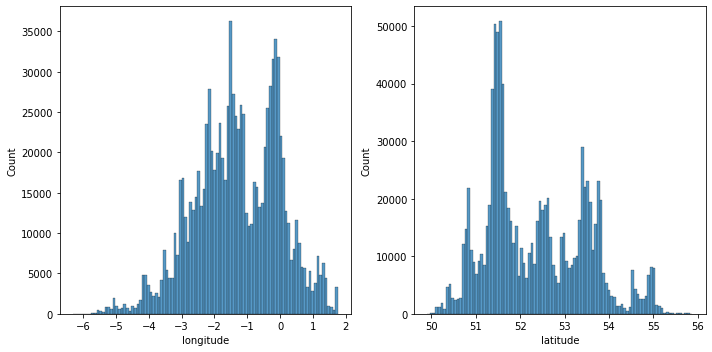

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))

features = ['longitude', 'latitude']

for axx, ft in zip(ax, features):
    sns.histplot(data[ft], bins = 100, ax = axx)
    
plt.tight_layout()

<AxesSubplot:>

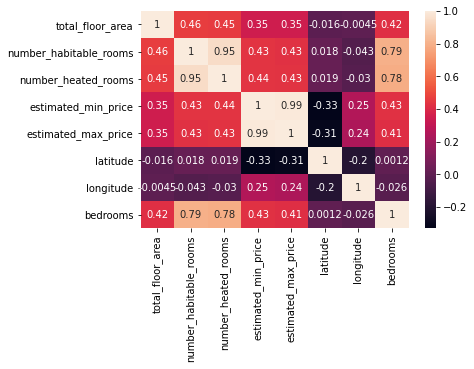

In [13]:
sns.heatmap(data.corr(), annot = True)

In [14]:
most_corr_feat = data.corr()['bedrooms'].sort_values(ascending=False).index[1:6]

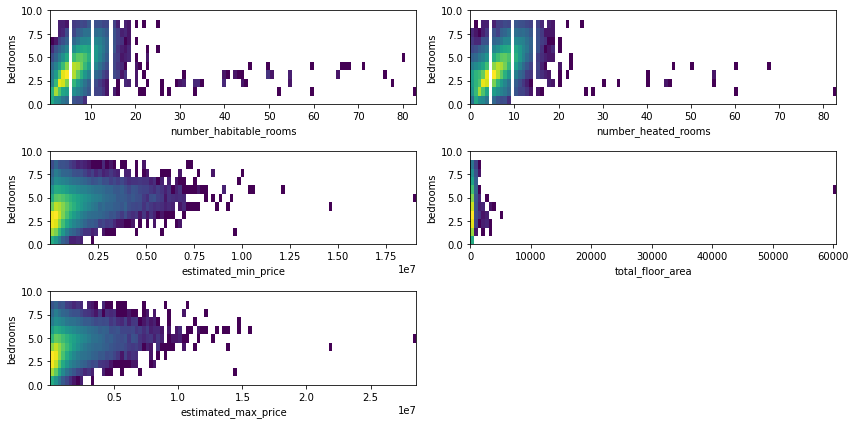

In [15]:
import matplotlib as mpl
fig, ax = plt.subplots(3,2, figsize = (12,6))
limits = []
for axx, ft in zip(ax.reshape(-1), most_corr_feat):
    h = axx.hist2d(x = data[ft], y = data['bedrooms'] , bins = [100,10], norm = mpl.colors.LogNorm())
    axx.set_xlabel(ft)
    axx.set_ylabel('bedrooms')
    axx.set_ylim(0,10)
    limits.append(axx.get_xlim())
fig.delaxes(ax.reshape(-1)[-1])
plt.tight_layout()

In [16]:
data_NoOutliers = data[data['total_floor_area'] < 1e4]
data_NoOutliers = data_NoOutliers[(data_NoOutliers['number_habitable_rooms'] < 25)]

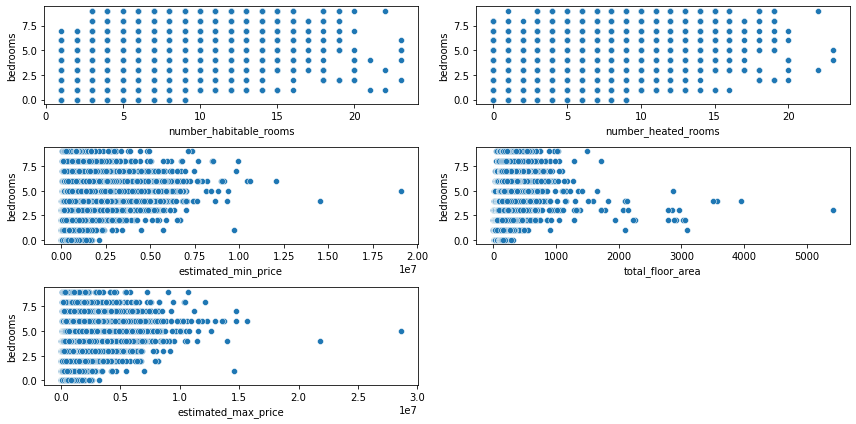

In [17]:
fig, ax = plt.subplots(3,2, figsize = (12,6))

for axx, ft in zip(ax.reshape(-1), most_corr_feat):
    sns.scatterplot(x = ft, y = 'bedrooms', data = data_NoOutliers, ax = axx)
    axx.set_xlabel(ft)
    axx.set_ylabel('bedrooms')
    
fig.delaxes(ax.reshape(-1)[-1])
plt.tight_layout()

In [18]:
# data['number_habitable_rooms'] = data['number_habitable_rooms'].map(lambda x: x if x <= 20 else '20+')
# data['number_heated_rooms'] = data['number_heated_rooms'].map(lambda x: x if x <= 20 else '20+')

In [19]:
# data = pd.get_dummies(data, columns = ['number_habitable_rooms', 'number_heated_rooms'])
# data['estimated_price'] = data.apply(lambda x: 0.5*(x['estimated_max_price'] + x['estimated_min_price']), axis = 1)

In [20]:
data['property_type'] = data['property_type'].map(lambda x: x[0])

In [21]:
data = pd.concat([data, pd.get_dummies(data['property_type'], drop_first = True)], axis = 1)
data.drop(labels = ['property_type'], axis = 1, inplace = True)

In [22]:
X = data.drop(labels = 'bedrooms', axis = 1)
y = data['bedrooms']

In [23]:
print(X.shape, y.shape)

(1000000, 10) (1000000,)


In [24]:
# y = pd.get_dummies(y, columns = ['bedrooms'])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [26]:
# y_train = y_train[X_train['total_floor_area'] < 1e4]
# X_train = X_train[X_train['total_floor_area'] < 1e4]
# y_train = y_train[X_train['number_habitable_rooms'] < 25]
# X_train = X_train[X_train['number_habitable_rooms'] < 25]

In [27]:
print(X_train.shape, y_train.shape)

(800000, 10) (800000,)


In [28]:
scl = MinMaxScaler()

In [29]:
X_train[:] = scl.fit_transform(X_train)
X_test[:] = scl.transform(X_test)

### KNeightbors calssification attempt

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
from sklearn.neighbors import KNeighborsClassifier

In [31]:
knn_clf=KNeighborsClassifier()

In [32]:
%%time
knn_clf.fit(X_train,y_train)

CPU times: user 471 ms, sys: 14.6 ms, total: 485 ms
Wall time: 485 ms


KNeighborsClassifier()

In [33]:
print(classification_report(y_test, knn_clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.48      0.29      0.36       551
           1       0.85      0.79      0.82     11288
           2       0.80      0.77      0.78     56617
           3       0.76      0.82      0.79     89463
           4       0.62      0.60      0.61     32220
           5       0.43      0.30      0.35      7623
           6       0.34      0.14      0.20      1721
           7       0.24      0.09      0.13       373
           8       0.17      0.06      0.08       109
           9       0.29      0.06      0.10        35

    accuracy                           0.74    200000
   macro avg       0.50      0.39      0.42    200000
weighted avg       0.73      0.74      0.74    200000



In [34]:
cm = confusion_matrix(y_test, knn_clf.predict(X_test), normalize='all')

<AxesSubplot:>

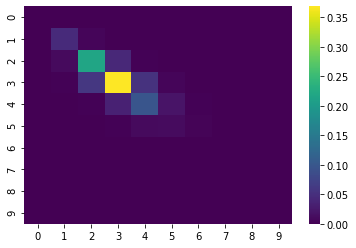

In [35]:
sns.heatmap(cm.T, cmap='viridis')

### Random Forest classification attempt

In [31]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf_model = RandomForestClassifier(n_jobs = -1)

In [33]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [34]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.49      0.27      0.35       551
           1       0.88      0.80      0.84     11288
           2       0.83      0.77      0.80     56617
           3       0.77      0.84      0.80     89463
           4       0.63      0.64      0.64     32220
           5       0.45      0.34      0.39      7623
           6       0.33      0.15      0.21      1721
           7       0.23      0.08      0.12       373
           8       0.13      0.05      0.07       109
           9       0.00      0.00      0.00        35

    accuracy                           0.76    200000
   macro avg       0.47      0.39      0.42    200000
weighted avg       0.75      0.76      0.75    200000



/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [35]:
cr = classification_report(y_test, rf_model.predict(X_test), output_dict = True)

/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [43]:
cr['accuracy']

0.757205

## XGBoost classification attempt

In [37]:
xgb_model = xgboost.XGBClassifier(objective='softmax:multi', n_jobs = -1, verbosity = 1)

In [38]:
%%time
xgb_model.fit(X_train, y_train)

/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:24:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 18min 22s, sys: 3min 19s, total: 21min 41s
Wall time: 2min 54s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=1)

In [39]:
print("Train score = {:2.4f} \t Test score = {:2.4f}"
      .format(xgb_model.score(X_train, y_train), xgb_model.score(X_test, y_test)))

Train score = 0.7705 	 Test score = 0.7602


In [40]:
print(classification_report(y_test, xgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.53      0.27      0.36       551
           1       0.88      0.80      0.84     11288
           2       0.84      0.75      0.79     56617
           3       0.77      0.85      0.81     89463
           4       0.64      0.66      0.65     32220
           5       0.47      0.35      0.40      7623
           6       0.36      0.13      0.19      1721
           7       0.27      0.06      0.10       373
           8       0.12      0.06      0.08       109
           9       0.50      0.06      0.10        35

    accuracy                           0.76    200000
   macro avg       0.54      0.40      0.43    200000
weighted avg       0.76      0.76      0.76    200000



## Neural Network model training attempt

In [254]:
def create_model():
    model = Sequential()
    model.add(Input(shape = (51,)))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(150, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), 
                  metrics=tf.keras.metrics.SparseCategoricalAccuracy())
    return model

In [40]:
def create_model_2():
    model = Sequential()
    model.add(Input(shape = (10,)))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01), 
                  metrics=tf.keras.metrics.SparseCategoricalAccuracy())
    return model

In [255]:
nn_model = create_model()
nn_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 150)               7800      
_________________________________________________________________
dense_29 (Dense)             (None, 150)               22650     
_________________________________________________________________
dense_30 (Dense)             (None, 100)               15100     
_________________________________________________________________
dense_31 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_32 (Dense)             (None, 40)                2040      
_________________________________________________________________
dense_33 (Dense)             (None, 20)                820       
_________________________________________________________________
dense_34 (Dense)             (None, 10)               

In [256]:
hst =    nn_model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=15,
                      verbose = 1,
                      batch_size = 128, 
                      use_multiprocessing=True)

Epoch 1/15
  19/6250 [..............................] - ETA: 38s - loss: 1.3927 - sparse_categorical_accuracy: 0.4762

2022-01-11 14:37:47.966608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6248/6250 [============================>.] - ETA: 0s - loss: 0.7095 - sparse_categorical_accuracy: 0.7310

2022-01-11 14:38:19.542514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 36s 6ms/step - loss: 0.7094 - sparse_categorical_accuracy: 0.7310 - val_loss: 0.6884 - val_sparse_categorical_accuracy: 0.7430
Epoch 2/15
6250/6250 [==============================] - 36s 6ms/step - loss: 0.6853 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.7462
Epoch 3/15
6250/6250 [==============================] - 35s 6ms/step - loss: 0.6812 - sparse_categorical_accuracy: 0.7455 - val_loss: 0.6777 - val_sparse_categorical_accuracy: 0.7457
Epoch 4/15
6250/6250 [==============================] - 36s 6ms/step - loss: 0.6799 - sparse_categorical_accuracy: 0.7452 - val_loss: 0.6923 - val_sparse_categorical_accuracy: 0.7415
Epoch 5/15
6250/6250 [==============================] - 38s 6ms/step - loss: 0.6790 - sparse_categorical_accuracy: 0.7463 - val_loss: 0.6744 - val_sparse_categorical_accuracy: 0.7504
Epoch 6/15
6250/6250 [==============================] - 39s 6ms/step - loss: 0.6813 - sparse_cat

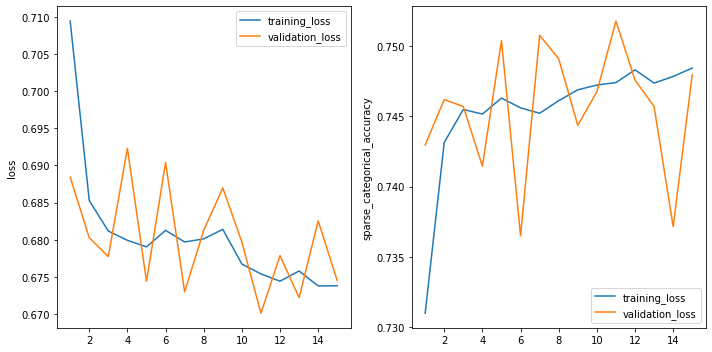

In [258]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x = range(1,16), y='loss', data = hst.history, label='training_loss', ax = ax[0])
sns.lineplot(x = range(1,16), y='val_loss', data = hst.history, label='validation_loss', ax = ax[0])
sns.lineplot(x = range(1,16), y='sparse_categorical_accuracy', data = hst.history, label='training_loss', ax = ax[1])
sns.lineplot(x = range(1,16), y='val_sparse_categorical_accuracy', data = hst.history, label='validation_loss', ax = ax[1])
plt.tight_layout()

In [280]:
y_pred = nn_model.predict_classes(X_test)

/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [281]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.44      0.58      0.50       551
           1       0.90      0.77      0.83     11288
           2       0.82      0.75      0.78     56617
           3       0.77      0.81      0.79     89463
           4       0.60      0.72      0.65     32220
           5       0.47      0.22      0.30      7623
           6       0.32      0.14      0.19      1721
           7       0.00      0.00      0.00       373
           8       0.00      0.00      0.00       109
           9       0.00      0.00      0.00        35

    accuracy                           0.75    200000
   macro avg       0.43      0.40      0.41    200000
weighted avg       0.75      0.75      0.74    200000



/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juansaizlomas/miniforge3/envs/dev-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [41]:
nn_model_2 = create_model_2()
nn_model_2.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                220       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
Total params: 850
Trainable params: 850
Non-trainable params: 0
_________________________________________________________________


2022-01-11 15:02:29.877895: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-11 15:02:29.878174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [43]:
hst =    nn_model_2.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      epochs=15,
                      verbose = 1,
                      batch_size = 128, 
                      use_multiprocessing=True)

2022-01-11 15:02:48.955040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-11 15:02:48.955407: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/15
  32/6250 [..............................] - ETA: 20s - loss: 1.7146 - sparse_categorical_accuracy: 0.3860

2022-01-11 15:02:49.171359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6242/6250 [============================>.] - ETA: 0s - loss: 0.7368 - sparse_categorical_accuracy: 0.7265

2022-01-11 15:03:08.863749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6250/6250 [==============================] - 23s 4ms/step - loss: 0.7367 - sparse_categorical_accuracy: 0.7266 - val_loss: 0.6967 - val_sparse_categorical_accuracy: 0.7383
Epoch 2/15
6250/6250 [==============================] - 24s 4ms/step - loss: 0.6842 - sparse_categorical_accuracy: 0.7425 - val_loss: 0.6803 - val_sparse_categorical_accuracy: 0.7441
Epoch 3/15
6250/6250 [==============================] - 25s 4ms/step - loss: 0.6776 - sparse_categorical_accuracy: 0.7443 - val_loss: 0.6722 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/15
6250/6250 [==============================] - 25s 4ms/step - loss: 0.6743 - sparse_categorical_accuracy: 0.7451 - val_loss: 0.6712 - val_sparse_categorical_accuracy: 0.7483
Epoch 5/15
6250/6250 [==============================] - 24s 4ms/step - loss: 0.6724 - sparse_categorical_accuracy: 0.7457 - val_loss: 0.6695 - val_sparse_categorical_accuracy: 0.7477
Epoch 6/15
6250/6250 [==============================] - 24s 4ms/step - loss: 0.6709 - sparse_cat

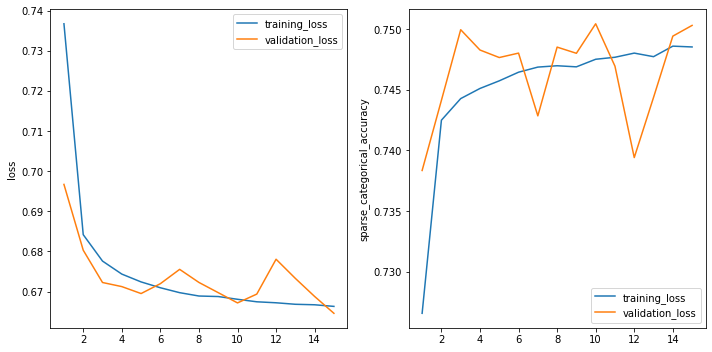

In [44]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(x = range(1,16), y='loss', data = hst.history, label='training_loss', ax = ax[0])
sns.lineplot(x = range(1,16), y='val_loss', data = hst.history, label='validation_loss', ax = ax[0])
sns.lineplot(x = range(1,16), y='sparse_categorical_accuracy', data = hst.history, label='training_loss', ax = ax[1])
sns.lineplot(x = range(1,16), y='val_sparse_categorical_accuracy', data = hst.history, label='validation_loss', ax = ax[1])
plt.tight_layout()